<a href="https://colab.research.google.com/github/KonstantinosKounakis/EleganSeg/blob/main/1_Demo_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec  8 11:11:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes.
!python -m pip install -U roifile
!pip install XlsxWriter
!pip install joblib
!pip install file-split-merge

import warnings
import os
warnings.filterwarnings('ignore')

try:
  os.mkdir('/content/EleganSeg')
except FileExistsError:
  pass

!git clone https://github.com/KonstantinosKounakis/EleganSeg.git
%cd /content/EleganSeg/

Cloning into 'EleganSeg'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 222 (delta 34), reused 102 (delta 24), pack-reused 90 (from 1)
Receiving objects: 100% (222/222), 439.62 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (46/46), done.
/content/EleganSeg


In [ ]:
#@title **Please, provide the necessary input files below:**

base = '/content/EleganSeg/'
## #@param {type:"string"}

checkpoint_SEG = '/content/EleganSeg/Data/network/SEG/'
## #@param {type:"string"}
checkpoint_SKL = '/content/EleganSeg/Data/network/SKL/'
## #@param {type:"string"}

test_images = '/content/EleganSeg/Data/demo_images/images/' #@param {type:"string"}
print('Input folder:', test_images)

## test_mask = '/content/EleganSeg/Data/demo_images/' #@param {type:"string"}
## print('Masks tagged:', test_mask)

save_dir = '/content/drive/MyDrive/demo_images/' #@param {type:"string"}
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print('Output:', save_dir)

Input folder: /content/EleganSeg/Data/demo_images/images/
Output: /content/drive/MyDrive/demo_images/


In [ ]:
#@title **Unzip networks, images**
import zipfile

# unzip networks
network_SEG = checkpoint_SEG + 'model.pth'
!file_split_merge -m -i $network_SEG

network_SKL = checkpoint_SKL + 'model.pth'
!file_split_merge -m -i $network_SKL

# unzip premade masks
## mask_zip = test_mask + 'mask.zip'
## path_save_maks = test_mask + 'masks/'

## with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
    ## zip_ref.extractall(path_save_maks)

##test_mask = path_save_maks


------------- STARTING FILE MERGE -------------

Merging the file to /content/EleganSeg/Data/network/SEG/model.pth
File Already Exist. Please remove the /content/EleganSeg/Data/network/SEG/model.pth and then re-run.

Do you want to remove the file [Y/N] : y
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 4 seconds

------------- STARTING FILE MERGE -------------

Merging the file to /content/EleganSeg/Data/network/SKL/model.pth
File Already Exist. Please remove the /content/EleganSeg/Data/network/SKL/model.pth and then re-run.

Do you want to remove the file [Y/N] : y
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 3 seconds


cuda


100%|██████████| 4/4 [00:16<00:00,  4.06s/img]

 
Image shown: Image89.tif


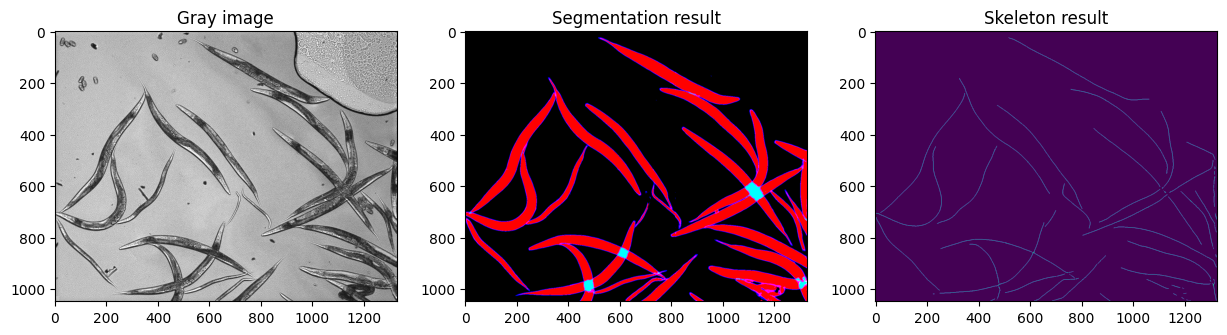

100%|██████████| 4/4 [00:17<00:00,  4.47s/img]


In [ ]:
#@title **Begin Evaluating**
from tqdm import tqdm
import cv2
import torch
import numpy as np
from PIL import Image
from utils import *
import matplotlib.pyplot as plt

end_gray_image = '.tif' #@param {type:"string"}
batch_crop_img = 9 #@param {type: "integer"}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

path_SKELETON = save_dir + '0_SKELETON/'
path_SEGMENTATION = save_dir + '0_SEGMENTATION/'

if not os.path.exists(path_SKELETON):
    os.makedirs(path_SKELETON)

if not os.path.exists(path_SEGMENTATION):
    os.makedirs(path_SEGMENTATION)

list_images = sorted(list_files(test_images, end_gray_image))

with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        # name_image = list_images[q]
        name_image_ = name_image.split('.')[0]
        name_image_save = name_image_ + '.bmp'
        path_image_gray = test_images + name_image

        image_gray = np.asarray(Image.open(path_image_gray))  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        h, w = image_gray.shape

        if not os.path.exists(path_SEGMENTATION + name_image_save):
            # Obtain segmentation from Network1
            dir_checkpoint_seg = checkpoint_SEG + 'model.pth'
            image_seg = get_image_network(device=device, dir_checkpoint=dir_checkpoint_seg, n_classes=4,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)

            # Obtain Skeleton from Network2
            dir_checkpoint_skl = checkpoint_SKL + 'model.pth'
            image_skl = get_image_network(device=device, dir_checkpoint=dir_checkpoint_skl, n_classes=1,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)
            cv2.imwrite(path_SEGMENTATION + name_image_save, image_seg)
            cv2.imwrite(path_SKELETON + name_image_save, image_skl)
        else:
            image_seg = cv2.imread(path_SEGMENTATION + name_image_save)
            image_skl = cv2.imread(path_SKELETON + name_image_save, cv2.IMREAD_GRAYSCALE)
        pbar.update(1)

    print(' ')
    print('Image shown:', name_image)
    name_image_00 = name_image
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(131)
    ax1.title.set_text('Gray image')
    ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

    ax2 = fig.add_subplot(132)
    ax2.title.set_text('Segmentation result')
    ax2.imshow(image_seg)

    ax3 = fig.add_subplot(133)
    ax3.title.set_text('Skeleton result')
    ax3.imshow(image_skl)
    plt.show()

Folder complete mask: /content/drive/MyDrive/demo_images/1_complete_mask/
Folder edge and small mask: /content/drive/MyDrive/demo_images/1_edge_small_mask/
Folder overlap masks: /content/drive/MyDrive/demo_images/1_overlap/
Folder save_results: /content/drive/MyDrive/demo_images/0_RGB_results/


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min finished


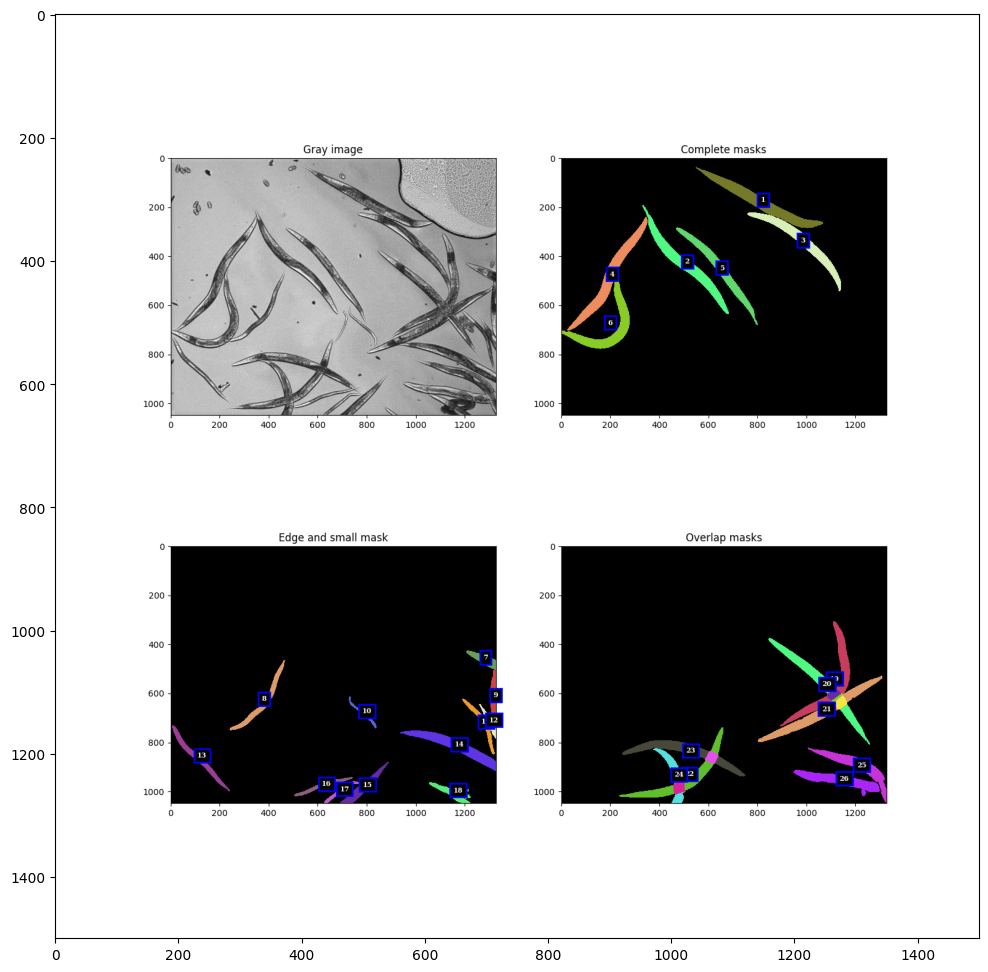

In [ ]:
#@title **Begin post-processing**
#@markdown Check if you want to split into subprocesses.
Parallel_process = True #@param {type:"boolean"}

#@markdown Enter the number of subprocesses to split.
N_process = 4 #@param {type:"number"}

area_percentage = 60
area_min = 600
kernel_size = 3
angle_value = 20

#@markdown Enter the paths  where the images will be saved.
path_save = '0_RGB_results/' #@param {type:"string"}
path_complete_mask = '1_complete_mask/' #@param {type:"string"}
path_edge_small_mask = '1_edge_small_mask/' #@param {type:"string"}
path_overlap = '1_overlap/' #@param {type:"string"}

path_save = save_dir + path_save
path_complete_mask = save_dir + path_complete_mask
path_edge_small_mask = save_dir + path_edge_small_mask
path_overlap = save_dir + path_overlap

print('Folder complete mask:', path_complete_mask)
print('Folder edge and small mask:', path_edge_small_mask)
print('Folder overlap masks:', path_overlap)
print('Folder save_results:', path_save)

import numpy as np
from utils import *
from skimage import measure
from joblib import Parallel, delayed

args = {'Parallel_process': Parallel_process,
        'path_images': test_images,
        'path_SEGMENTATION': path_SEGMENTATION,
        'path_SKELETON': path_SKELETON,
        'path_complete_mask': path_complete_mask,
        'path_edge_small_mask': path_edge_small_mask,
        'path_overlap': path_overlap,
        'path_save': path_save,
        'area_percentage': area_percentage,
        'area_min': area_min,
        'kernel_size': kernel_size,
        'angle_value': angle_value
        }

def post_processing(args, name_image):
    name_image_ = name_image.split('.')[0]
    name_image_save = name_image_ + '.bmp'
    image_seg = cv2.imread(args['path_SEGMENTATION'] + name_image_save)

    if not os.path.exists(args['path_save'] + name_image_ + '.png'):
        image_skl = cv2.imread(args['path_SKELETON'] + name_image_save)
        image_skl = (cv2.cvtColor(image_skl, cv2.COLOR_BGR2GRAY) > 0) * 255

        area_min = args['area_min']
        angle_value = args['angle_value']
        kernel_size = args['kernel_size']
        area_percentage = args['area_percentage']

        path_images = args['path_images']
        path_complete_mask = args['path_complete_mask']
        path_edge_small_mask = args['path_edge_small_mask']
        path_overlap = args['path_overlap']
        path_save = args['path_save']

        if not os.path.exists(path_complete_mask):
            try:
              os.makedirs(path_complete_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_edge_small_mask):
            try:
              os.makedirs(path_edge_small_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_overlap):
            try:
              os.makedirs(path_overlap)
            except FileExistsError:
              pass

        if not os.path.exists(path_save):
            try:
              os.makedirs(path_save)
            except FileExistsError:
              pass


        # ***************** Improve edge detection ****************************************************
        edge_final = check_edge_worms(image_seg, kernel_size)

        # ***************** none overlappings and overlappings *******************************************
        none_overlappings, overlapping = obtain_overlappings(image_seg, edge_final, kernel_size + 2)
        labels_overlapping = measure.label(overlapping, background=0)
        labels_none_overlapping = measure.label(none_overlappings, background=0)

        # ************************** None-overlappings ***************************************************
        true_overlaps = check_overlapping(labels_overlapping, labels_none_overlapping)
        mask_worms = get_none_overlapping(labels_none_overlapping, true_overlaps, area_min, kernel_size)  # none-overl
        mask_worms_Dims = worms2NDims(mask_worms, kernel_size + 2)  # each dimension is a worm
        results_masks_NO = check_noneOverlapping(mask_worms_Dims, area_percentage)  # Check good/bad masks

        # ************************** overlappings ********************************************************
        mask_overlaps_Dims = overlapping_worms(true_overlaps, mask_worms, labels_overlapping,
                                               labels_none_overlapping, image_skl, area_min,
                                               kernel_size+2, angle_value)

        # ***************************** Save imgs results *****************************************************
        name_image_final = path_save + name_image_ + '.png'
        path_image_gray = path_images + name_image
        image_gray = imread_image(path_image_gray)  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        save_results_mask(name_image_final, image_gray, results_masks_NO, mask_overlaps_Dims, 1)  # RGB

        save_mask_tif(path_complete_mask + name_image, results_masks_NO['worms_good'])
        save_mask_tif(path_edge_small_mask + name_image, results_masks_NO['worms_bads'])
        save_mask_tif(path_overlap + name_image, mask_overlaps_Dims)

if Parallel_process:
    Parallel(n_jobs=N_process, verbose=1, backend='multiprocessing')(
        delayed(post_processing)(args, name_image) for name_image in list_images)
else:
    with tqdm(total=len(list_images), unit='img') as pbar:
        for name_image in list_images:
            post_processing(args, name_image)
            pbar.update(1)

## Show results masks
name_image_showed = name_image_00
name_image_ = name_image_showed.split('.')[0]
name_image_result = path_save + name_image_ + '.png'
image_result = cv2.imread(name_image_result)

plt.figure(figsize=(15, 15))
plt.imshow(image_result)
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()

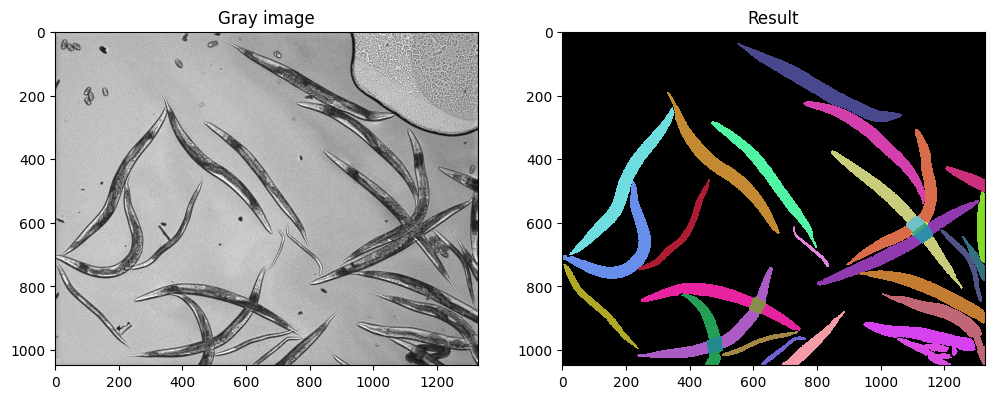

In [54]:
#@title **Show masks**
#@markdown Displays all masks in one picture

## Show all results
from utils import imread_image, read_tiff_mask, Ndims2image
path_image_gray = test_images + name_image_showed
image_gray = imread_image(path_image_gray)  # read gray image
if len(image_gray.shape) > 2:
    image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)

image_complete_mask = path_complete_mask + name_image_showed
image_edge_small_mask = path_edge_small_mask + name_image_showed
image_overlap_mask = path_overlap + name_image_showed

image_complete_mask = read_tiff_mask(image_complete_mask)
image_edge_small_mask = read_tiff_mask(image_edge_small_mask)
try:
    image_overlap_mask = read_tiff_mask(image_overlap_mask)
except:
    if len(image_complete_mask.shape) == 2:
        h, w = image_complete_mask.shape
    else:
        d, h, w = image_complete_mask.shape
    image_overlap_mask = np.zeros((0, h, w), dtype="uint8")

masK_predict_all = np.concatenate((image_complete_mask, image_edge_small_mask), axis=0)
masK_predict_all = np.concatenate((masK_predict_all, image_overlap_mask), axis=0)
worms_all, new_map = Ndims2image(masK_predict_all, 1)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Gray image')
ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

ax2 = fig.add_subplot(122)
ax2.title.set_text('Result')
ax2.imshow(worms_all, cmap=new_map, interpolation='None')
fig = plt.gcf()
fig.set_size_inches(12, 12)

Image selected: Image132.tif
Worms good:  ['1', '2', '3', '4', '5', '6', '7', '18']
Worms bad:  ['8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '19', '20', '21', '22', '23', '24', '25']


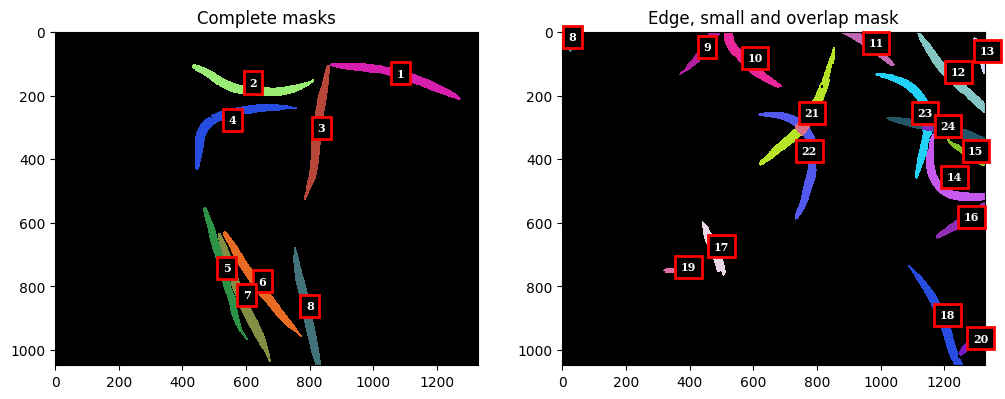

In [62]:
#@title **Mask correction**
#@markdown Corrects complete, edge, small and overlapping masks
import warnings
warnings.filterwarnings('ignore')

name_image_change = 'Image132.tif' #@param {type:"string"}
print('Image selected:', name_image_change)
index_images = '1,2,3,4,5,6,7,18' #@param {type:"string"}

image_complete_mask = path_complete_mask + name_image_change
image_edge_small_mask = path_edge_small_mask + name_image_change

image_complete_mask = read_tiff_mask(image_complete_mask)
image_edge_small_mask = read_tiff_mask(image_edge_small_mask)

masK_predict_all = np.concatenate((image_complete_mask, image_edge_small_mask), axis=0)

try:
  image_overlap_mask = path_overlap + name_image_change
  image_overlap_mask = read_tiff_mask(image_overlap_mask)
  masK_predict_all = np.concatenate((masK_predict_all, image_overlap_mask), axis=0)
except:
  rt = -1

all_elements = []
for i in range(1, masK_predict_all.shape[0] + 1):
    all_elements.append(str(i))

index_images = index_images.split(',')
all_elements = all_elements + index_images
index_bad = [i for i in all_elements if all_elements.count(i) == 1]

print('Worms good: ', index_images)
print('Worms bad: ', index_bad)
worms_true = np.zeros((len(index_images), masK_predict_all.shape[1], masK_predict_all.shape[2]), np.int8)
for i in range(len(index_images)):
    index = int(index_images[i])
    worms_true[i, :, :] = masK_predict_all[index - 1, :, :]

worms_bad = np.zeros((len(index_bad), masK_predict_all.shape[1], masK_predict_all.shape[2]), np.int8)
for i in range(len(index_bad)):
    index = int(index_bad[i])
    worms_bad[i, :, :] = masK_predict_all[index - 1, :, :]

worms_true = (worms_true != 0) * 255
worms_bad = (worms_bad != 0) * 255

worms_all_true, new_map = Ndims2image(worms_true, 1)
worms_all_bad, _ = Ndims2image(worms_bad, 1)

centroid_predict_true, label_predict_true = get_centroid(worms_true, 1)
centroid_predict_bad, label_predict_bad = get_centroid(worms_bad, len(index_images))

# show images results
font = {'family': 'serif',
        'color': 'white',
        'weight': 'bold',
        'size': 8,
        }

bbox = {'facecolor': 'black',
        'edgecolor': 'red',
        'linewidth': 2
        }

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Complete masks')
ax1.imshow(worms_all_true, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_true)):
    ax1.text(centroid_predict_true[i][1], centroid_predict_true[i][0], label_predict_true[i], fontdict=font, bbox=bbox)

ax2 = fig.add_subplot(122)
ax2.title.set_text('Edge, small and overlap mask')
ax2.imshow(worms_all_bad, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_bad)):
    ax2.text(centroid_predict_bad[i][1], centroid_predict_bad[i][0], label_predict_bad[i], fontdict=font, bbox=bbox)
fig = plt.gcf()
fig.set_size_inches(12, 12)

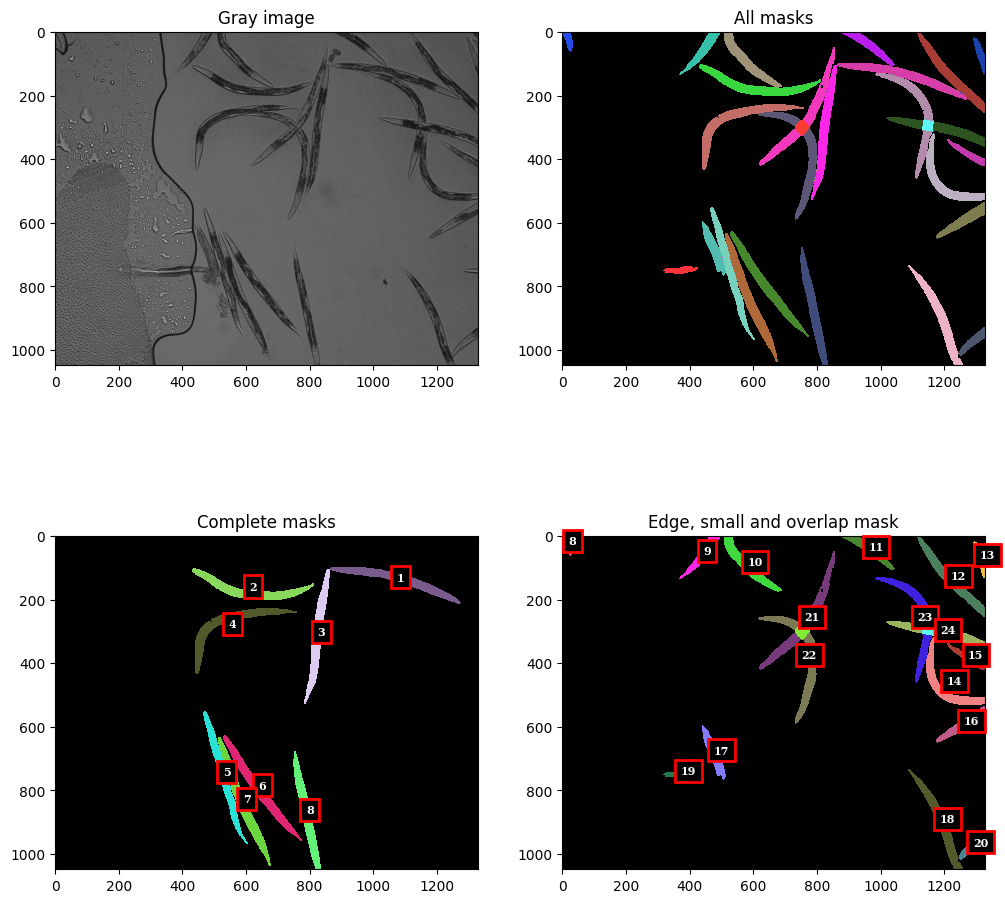

In [64]:
#@title **Save corrected masks**
#@markdown Save complete, edge, small and overlap mask. Overlapping masks will be removed.
# save results
import os
import shutil

name_image_change = 'Image132.tif' #@param {type:"string"}

tifffile.imsave(path_complete_mask + name_image_change, worms_true.astype(np.uint8))
tifffile.imsave(path_edge_small_mask + name_image_change, worms_bad.astype(np.uint8))
try:
  os.remove(path_overlap + name_image_change)
except:
  print('Files does not exist')


path_image_gray = test_images + name_image_change
image_gray = imread_image(path_image_gray)  # read gray image
if len(image_gray.shape) > 2:
    image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
worms_all, new_map = Ndims2image(masK_predict_all, 1)

# show images results
font = {'family': 'serif',
        'color': 'white',
        'weight': 'bold',
        'size': 8,
        }

bbox = {'facecolor': 'black',
        'edgecolor': 'red',
        'linewidth': 2
        }

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Gray image')
ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

ax2 = fig.add_subplot(222)
ax2.title.set_text('All masks')
ax2.imshow(worms_all, cmap=new_map, interpolation='None')

ax3 = fig.add_subplot(223)
ax3.title.set_text('Complete masks')
ax3.imshow(worms_all_true, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_true)):
    ax3.text(centroid_predict_true[i][1], centroid_predict_true[i][0], label_predict_true[i], fontdict=font, bbox=bbox)

ax4 = fig.add_subplot(224)
ax4.title.set_text('Edge, small and overlap mask')
ax4.imshow(worms_all_bad, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_bad)):
    ax4.text(centroid_predict_bad[i][1], centroid_predict_bad[i][0], label_predict_bad[i], fontdict=font, bbox=bbox)

name_image_change_ = name_image_change.split('.')[0]
name_image_result = path_save + name_image_change_ + '.jpg'
plt.savefig(name_image_result)

fig = plt.gcf()
fig.set_size_inches(12, 12)

In [ ]:
#@title **Save rois**
#@markdown Save complete mask in rois
folder_rois_results = '2_rois_results' #@param {type:"string"}
folder_rois_results = save_dir + '/' + folder_rois_results + '/'
print(folder_rois_results)

from utils import list_files, save_mask_rois
if not os.path.exists(folder_rois_results):
    os.makedirs(folder_rois_results)

list_images = sorted(list_files(path_complete_mask, end_gray_image))
with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        image_good_mask = path_complete_mask + name_image
        image_good_mask = read_tiff_mask(image_good_mask)
        name_image_ = name_image.split('.')[0]
        name_zip_save = folder_rois_results + name_image_ + '.zip'
        save_mask_rois(name_zip_save, image_good_mask)
        pbar.update(1)

/content/drive/MyDrive/demo_images//2_rois_results/


100%|██████████| 4/4 [00:02<00:00,  1.68img/s]
